[py4kids](https://github.com/wgong/py4kids)

In this lesson, we learn how to work with [SQLite](https://www.sqlite.org/index.html) database, [pandas](http://pandas.pydata.org/pandas-docs/stable/?v=20180118160012), [basemap](https://matplotlib.org/basemap/users/examples.html).

It is based upon blog: [Working with SQLite Databases using Python and Pandas](https://www.dataquest.io/blog/python-pandas-databases/)

## pre-requisite

Assume Anaconda3 is already installed

1) install SQLite

CMD> conda install sqlite

2) install pandas

CMD> conda install pandas

3) install Basemap

CMD>  conda install basemap

Download [flights.db](https://www.dropbox.com/s/a2wax843eniq12g/flights.db?dl=0) sample database

In [16]:
import sqlite3

import pandas as pd

from mpl_toolkits.basemap import Basemap

import matplotlib.pyplot as plt

## use flights SQlite db in python

In [9]:
# create connection
conn = sqlite3.connect("flights.db")

# create cursor for query
cur = conn.cursor()

In [10]:
cur.execute("select * from airlines limit 5;")

In [11]:
results = cur.fetchall()
print(results)

[(0, '1', 'Private flight', '\\N', '-', None, None, None, 'Y'), (1, '2', '135 Airways', '\\N', None, 'GNL', 'GENERAL', 'United States', 'N'), (2, '3', '1Time Airline', '\\N', '1T', 'RNX', 'NEXTIME', 'South Africa', 'Y'), (3, '4', '2 Sqn No 1 Elementary Flying Training School', '\\N', None, 'WYT', None, 'United Kingdom', 'N'), (4, '5', '213 Flight Unit', '\\N', None, 'TFU', None, 'Russia', 'N')]


## Mapping airports

[Plotting data on a map (Example Gallery)](https://matplotlib.org/basemap/users/examples.html)

In [12]:
coords = cur.execute("""
  select cast(longitude as float), 
  cast(latitude as float) 
  from airports;"""
).fetchall()

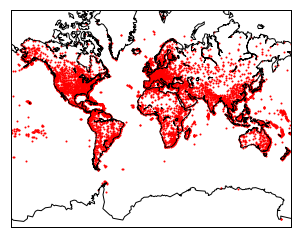

In [15]:
m = Basemap(
  projection='merc',
  llcrnrlat=-80,
  urcrnrlat=80,
  llcrnrlon=-180,
  urcrnrlon=180,
  lat_ts=20,
  resolution='c'
)

m.drawcoastlines()
m.drawmapboundary()

x, y = m(
  [l[0] for l in coords], 
  [l[1] for l in coords]
)

m.scatter(
  x,
  y,
  1,
  marker='o',
  color='red'
)


plt.show()

## work with pandas DataFrame

In [17]:
df = pd.read_sql_query("select * from airlines limit 5;", conn)
df

,index,id,name,alias,iata,icao,callsign,country,active
0,0,1,Private flight,\N,-,None,None,None,Y
1,1,2,135 Airways,\N,None,GNL,GENERAL,United States,N
2,2,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
3,3,4,2 Sqn No 1 Elementary Flying Training School,\N,None,WYT,None,United Kingdom,N
4,4,5,213 Flight Unit,\N,None,TFU,None,Russia,N


In [18]:
df["country"]

0              None
1     United States
2      South Africa
3    United Kingdom
4            Russia
Name: country, dtype: object

### Mapping routes

In [20]:
routes = pd.read_sql_query("""
                           select cast(sa.longitude as float) as source_lon, 
                           cast(sa.latitude as float) as source_lat,
                           cast(da.longitude as float) as dest_lon,
                           cast(da.latitude as float) as dest_lat
                           from routes 
                           inner join airports sa on
                           sa.id = routes.source_id
                           inner join airports da on
                           da.id = routes.dest_id;
                           """, 
                           conn)

m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()

# draw first 3000 routes

for name, row in routes[:3000].iterrows():
    if abs(row["source_lon"] - row["dest_lon"]) < 90:
        # Draw a great circle between source and dest airports.
        m.drawgreatcircle(
            row["source_lon"], 
            row["source_lat"], 
            row["dest_lon"],
            row["dest_lat"],
            linewidth=1,
            color='b'
        )

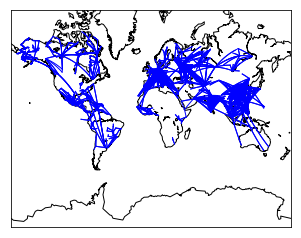

In [21]:
plt.show()

## Modifying database

How to insert, update, or delete table rows

### Insert

In [22]:
cur.execute("insert into airlines values (6048, 19846, 'Test flight', '', '', null, null, null, 'Y')")
conn.commit()

In [23]:
# verify the inserted row

t1 = pd.read_sql_query("select * from airlines where id=19846;", conn)
t1

,index,id,name,alias,iata,icao,callsign,country,active
0,6048,19846,Test flight,,,None,None,None,Y


In [27]:
index_val = 6049
id_val = 19847
name_val = 'Test flight2'

In [31]:
cur.execute("insert into airlines values ({0}, {1}, '{2}', '', '', null, null, null, 'Y')".format(index_val, id_val, name_val))
conn.commit()

In [32]:
# verify the inserted row

t2 = pd.read_sql_query("select * from airlines where id=19847;", conn)
t2

,index,id,name,alias,iata,icao,callsign,country,active
0,6049,19847,Test flight2,,,None,None,None,Y


In [33]:
#  inject dynamic values without relying on string formatting

row_values = (6050, 19848, 'Test flight-3', 'N')
cur.execute("insert into airlines values (?, ?, ?, '', '', null, null, null, ?)", row_values)
conn.commit()

In [34]:
# verify the inserted row

t3 = pd.read_sql_query("select * from airlines where id=19848;", conn)
t3

,index,id,name,alias,iata,icao,callsign,country,active
0,6050,19848,Test flight-3,,,None,None,None,N


### Update

In [37]:
row_values = ('Test Flight Two','US', 19847)
cur.execute("update airlines set name=?, country=? where id=?", row_values)
conn.commit()

In [39]:
###### verify the updated row

t2 = pd.read_sql_query("select * from airlines where id=19847;", conn)
t2

,index,id,name,alias,iata,icao,callsign,country,active
0,6049,19847,Test Flight Two,,,None,None,US,Y


### Delete

In [40]:
row_values = (19846, )
cur.execute("delete from airlines where id=?", row_values)
conn.commit()

In [41]:
# verify the deleted row

t1 = pd.read_sql_query("select * from airlines where id=19846;", conn)
t1

,index,id,name,alias,iata,icao,callsign,country,active


## Creating tables

In [42]:
cur.execute("create table daily_flights (id integer, departure date, arrival date, number text, route_id integer)")
conn.commit()

In [43]:
# insert one row
cur.execute("insert into daily_flights values (1, '2016-09-28 0:00', '2016-09-28 12:00', 'T1', 1)")
conn.commit()

In [44]:
t4 = pd.read_sql_query("select * from daily_flights;", conn)
t4

,id,departure,arrival,number,route_id
0,1,2016-09-28 0:00,2016-09-28 12:00,T1,1


### Create table with pandas

The pandas package gives us a much faster way to create tables. We just have to create a DataFrame first, then export it to a SQL table

In [45]:
from datetime import datetime
df = pd.DataFrame(
    [
        [1, datetime(2016, 9, 29, 0, 0) , datetime(2016, 9, 29, 12, 0), 'T1', 1],
        [2, datetime(2018, 9, 29, 0, 0) , datetime(2018, 9, 30, 12, 0), 'T2', 1]
    ], 
    columns=["id", "departure", "arrival", "number", "route_id"]
)

df.to_sql("daily_flights", conn, if_exists="replace")   # append is another option

In [46]:
t5 = pd.read_sql_query("select * from daily_flights;", conn)
t5

,index,id,departure,arrival,number,route_id
0,0,1,2016-09-29 00:00:00,2016-09-29 12:00:00,T1,1
1,1,2,2018-09-29 00:00:00,2018-09-30 12:00:00,T2,1


## Altering table

In [50]:
cur.execute("alter table airlines add column airplanes integer;")

# no need to call commit for altering table

OperationalError: duplicate column name: airplanes

### Altering tables with Pandas

In [51]:
df = pd.read_sql("select * from daily_flights", conn)
df["delay_minutes"] = None
df.to_sql("daily_flights", conn, if_exists="replace")

In [52]:
t5 = pd.read_sql_query("select * from daily_flights;", conn)
t5

,level_0,index,id,departure,arrival,number,route_id,delay_minutes
0,0,0,1,2016-09-29 00:00:00,2016-09-29 12:00:00,T1,1,None
1,1,1,2,2018-09-29 00:00:00,2018-09-30 12:00:00,T2,1,None


## Cleanup

it's good practice to close Connection objects and Cursor objects that are open. This prevents the SQLite database from being locked

In [5]:
cur.close()
conn.close()